In [1]:
import tensorflow as tf 
tf.enable_eager_execution()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import itertools
import os

experiment_name = "VAEMultipleShapesNoColor"

In [3]:
dataset = np.load('dsprites-dataset/dsprites_multiple_shapes_no_color.npz.npy')

In [4]:
def show_images_grid(imgs_, num_images=25):
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()

    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')

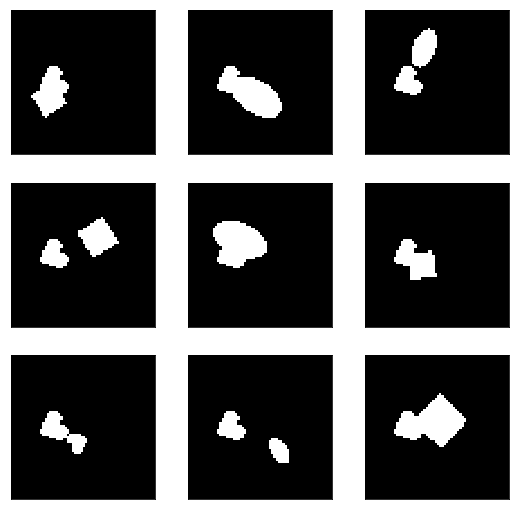

In [5]:
show_images_grid(np.squeeze(dataset), 9)

In [6]:
dataset = dataset[:100000].astype('float32')

In [7]:
dataset.shape

(100000, 64, 64, 1)

In [8]:
TRAIN_BUF = 100000
BATCH_SIZE = 100

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(TRAIN_BUF).batch(BATCH_SIZE)

In [10]:
class VAESprite(tf.keras.Model):
    """Same Architecture"""
    def __init__(self, latent_dim, num_object):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_object = num_object
        
        self.encoder1 = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(64, 64, 1)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=4, strides=(2, 2), activation=tf.nn.elu),
            tf.keras.layers.Conv2D(filters=32, kernel_size=2, strides=(1, 1), activation=tf.nn.elu),
        ])
        
        self.encoder2 = tf.keras.Sequential([       
            tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=(2, 2), activation=tf.nn.elu),
            tf.keras.layers.Conv2D(filters=24, kernel_size=1, strides=(1, 1), activation=tf.nn.elu),
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=4*4*64, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(4, 4, 64)),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=(2, 2), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=(2, 2), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=(2, 2), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=(2, 2), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=1, strides=(1, 1), padding="SAME"),
        ])
    
    def call(self, img, is_sigmoid=False):
        """Reuse the code from the Google Example"""
        encoder1 = self.encoder1(img)
        
        # Adding x, y coordinate
        x = tf.convert_to_tensor([-14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 
                                  0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])/15
        y = tf.convert_to_tensor([-14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 
                                  0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])/15
        
        X, Y = tf.meshgrid(x, y)
        X, Y = tf.expand_dims(tf.cast(X, tf.float32), -1), tf.expand_dims(tf.cast(Y, tf.float32), -1)
        X, Y = tf.expand_dims(tf.cast(X, tf.float32), 0), tf.expand_dims(tf.cast(Y, tf.float32), 0)
        
        X, Y = tf.tile(X, [encoder1.shape[0], 1, 1, 1]), tf.tile(X, [encoder1.shape[0], 1, 1, 1])
        
        encoder_pos = tf.concat([encoder1, X, Y], -1)
        encoder_final = self.encoder2(encoder_pos)
        
        encoder_flatten = tf.reshape(encoder_final, (tf.shape(encoder_final)[0], 
                                                    -1, tf.shape(encoder_final)[-1]))
        mean, log_var = tf.split(encoder_flatten, num_or_size_splits=2, axis=-1)
        
        # Getting Analytic-KL
        kl = 0.5 * tf.reduce_sum(tf.exp(log_var) + mean**2 - 1. - log_var, axis=[-1])
        total_kl_value, total_kl_index = tf.math.top_k(kl, k=self.num_object)
        
        # Getting top 2
        top_latent_mean = tf.batch_gather(mean, total_kl_index)
        top_latent_log_var = tf.batch_gather(log_var, total_kl_index)
        
        # Getting latents for each objects 
        normal = tf.random_normal(shape=top_latent_mean.shape)
        each_latent = normal * tf.exp(top_latent_log_var * .5) + top_latent_mean
        
        # Should I do this ? 
        latents = tf.reshape(each_latent, (-1, self.latent_dim))
        decoded = self.decoder(latents)
        
        imgs = tf.reshape(decoded, (-1, self.num_object, decoded.shape[1], 
                                       decoded.shape[2], decoded.shape[3]))
        
        # Add all images 
        final_images = tf.reduce_sum(imgs, axis=1)
        return each_latent, final_images, top_latent_mean, top_latent_log_var, kl

In [11]:
latent_size = 12
object_number = 2

learning_rate = 1e-3

def get_learning_rate():
    global learning_rate
    learning_rate *= 0.9999984649444495
    return learning_rate

In [12]:
vae = VAESprite(latent_size, object_number)
optimizer = tf.train.AdamOptimizer(learning_rate=get_learning_rate)

global_step = tf.train.get_or_create_global_step()
summary_writer = tf.contrib.summary.create_file_writer(f"tmp/{experiment_name}")

saver = tf.train.Checkpoint(optimizer=optimizer,
                            model=vae,
                            optimizer_step=tf.train.get_or_create_global_step())

save_path = f"save/{experiment_name}"
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [13]:
for e in range(300):
    print(f"At epoch {e}")
    for i, img in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            tape.watch(vae.variables)

            latent, out, mean, log_var, kl_map = vae(img)
            flat_mean = tf.reshape(mean, (-1, latent_size))
            flat_log_var = tf.reshape(log_var, (-1, latent_size))

            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=out, labels=img)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
            kl_loss = 0.5 * tf.reduce_sum(tf.exp(flat_log_var) + flat_mean**2 - 1. - flat_log_var, 
                                          axis=[1])
            kl_loss = tf.reduce_sum(tf.reshape(kl_loss, (-1, object_number)), axis=1)
            loss = -tf.reduce_mean(logpx_z - kl_loss)

            if i % 100 == 0:
                print(f"Loss -- {loss}   Current Learning Rate {learning_rate}")
                with summary_writer.as_default(), tf.contrib.summary.always_record_summaries():
                    tf.contrib.summary.scalar('Loss', loss)
                    tf.contrib.summary.image('Before', img)
                    tf.contrib.summary.image('Sample', tf.nn.sigmoid(out))
                    
        
        grad = tape.gradient(loss, vae.variables)
        global_step.assign_add(1)
        optimizer.apply_gradients(zip(grad, vae.variables))
        
    print(f"---------")
    saver.save(f"save/{experiment_name}/{experiment_name}.ckpt")

At epoch 0
Loss -- 2839.8603515625   Current Learning Rate 0.001
Loss -- 846.439453125   Current Learning Rate 0.0009998465061085268
Loss -- 782.0558471679688   Current Learning Rate 0.00099969303577743
Loss -- 756.008544921875   Current Learning Rate 0.0009995395890030907
Loss -- 756.0664672851562   Current Learning Rate 0.0009993861657818946
Loss -- 725.5579833984375   Current Learning Rate 0.000999232766110225
Loss -- 685.2756958007812   Current Learning Rate 0.0009990793899844694
Loss -- 724.1875610351562   Current Learning Rate 0.0009989260374010107
Loss -- 713.190185546875   Current Learning Rate 0.0009987727083562378
Loss -- 710.5396118164062   Current Learning Rate 0.0009986194028465364
---------
At epoch 1
Loss -- 687.5068969726562   Current Learning Rate 0.000998466120868294
Loss -- 665.0042114257812   Current Learning Rate 0.0009983128624178985
Loss -- 676.4312744140625   Current Learning Rate 0.0009981596274917398
Loss -- 632.8388061523438   Current Learning Rate 0.00099800

Loss -- 305.82196044921875   Current Learning Rate 0.0009829543146366926
Loss -- 353.1739807128906   Current Learning Rate 0.0009828034371538003
Loss -- 311.3593444824219   Current Learning Rate 0.0009826525828296807
Loss -- 340.68359375   Current Learning Rate 0.000982501751660778
Loss -- 355.1368103027344   Current Learning Rate 0.0009823509436435378
Loss -- 346.6053161621094   Current Learning Rate 0.0009822001587744065
Loss -- 347.104248046875   Current Learning Rate 0.000982049397049831
Loss -- 291.09332275390625   Current Learning Rate 0.0009818986584662606
---------
At epoch 12
Loss -- 321.71795654296875   Current Learning Rate 0.000981747943020142
Loss -- 317.8678894042969   Current Learning Rate 0.000981597250707923
Loss -- 313.17852783203125   Current Learning Rate 0.0009814465815260534
Loss -- 303.6146545410156   Current Learning Rate 0.0009812959354709842
Loss -- 329.03765869140625   Current Learning Rate 0.000981145312539163
Loss -- 308.5510559082031   Current Learning Rat

Loss -- 282.05621337890625   Current Learning Rate 0.0009663475131031995
Loss -- 244.62484741210938   Current Learning Rate 0.0009661991846628994
Loss -- 302.17266845703125   Current Learning Rate 0.0009660508789901079
Loss -- 272.8968811035156   Current Learning Rate 0.0009659025960813318
Loss -- 277.6354064941406   Current Learning Rate 0.0009657543359330767
Loss -- 279.40777587890625   Current Learning Rate 0.000965606098541848
Loss -- 261.5422668457031   Current Learning Rate 0.0009654578839041538
---------
At epoch 23
Loss -- 245.94265747070312   Current Learning Rate 0.0009653096920165011
Loss -- 292.3544006347656   Current Learning Rate 0.000965161522875398
Loss -- 300.3241882324219   Current Learning Rate 0.0009650133764773521
Loss -- 265.1915588378906   Current Learning Rate 0.0009648652528188737
Loss -- 257.6287536621094   Current Learning Rate 0.0009647171518964724
Loss -- 256.72235107421875   Current Learning Rate 0.0009645690737066583
Loss -- 256.3341369628906   Current Le

Loss -- 237.69117736816406   Current Learning Rate 0.0009500212799064642
Loss -- 252.71580505371094   Current Learning Rate 0.0009498754574432299
Loss -- 210.03765869140625   Current Learning Rate 0.0009497296573628529
Loss -- 252.3270263671875   Current Learning Rate 0.0009495838796618983
Loss -- 254.95640563964844   Current Learning Rate 0.0009494381243369304
Loss -- 279.1491394042969   Current Learning Rate 0.0009492923913845141
---------
At epoch 34
Loss -- 261.0584411621094   Current Learning Rate 0.0009491466808012157
Loss -- 265.0417785644531   Current Learning Rate 0.0009490009925836022
Loss -- 250.34921264648438   Current Learning Rate 0.000948855326728239
Loss -- 252.2300262451172   Current Learning Rate 0.0009487096832316957
Loss -- 239.07928466796875   Current Learning Rate 0.0009485640620905388
Loss -- 256.37420654296875   Current Learning Rate 0.0009484184633013377
Loss -- 241.4615020751953   Current Learning Rate 0.0009482728868606611
Loss -- 235.75682067871094   Current

KeyboardInterrupt: 

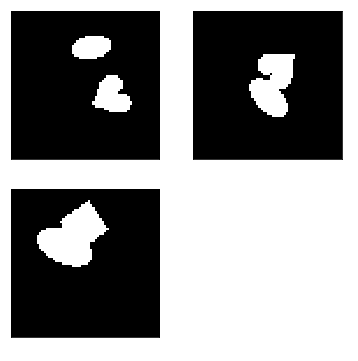

In [14]:
show_images_grid(tf.squeeze(img).numpy(), 3)

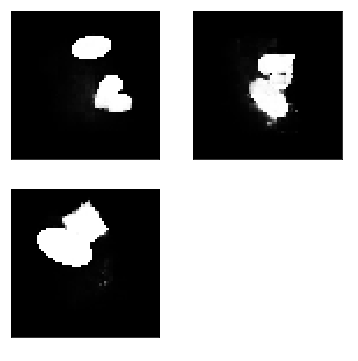

In [15]:
show_images_grid(tf.squeeze(tf.nn.sigmoid(out)).numpy(), 3)

In [16]:
def get_kl_attention_map(kl_index):
    batch_size = kl_index.shape[0]
    blank_map = np.zeros((batch_size, 14*14))
    for i in range(batch_size):
        blank_map[i] = kl_index[i]
    return blank_map.reshape(batch_size, 14, 14)

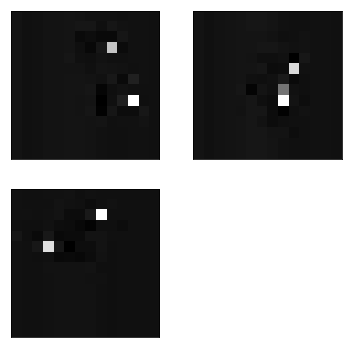

In [17]:
show_images_grid(get_kl_attention_map(kl_map), 3)